<b>Problem statement:</b> To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Data Summary:**

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:
1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion

### Importing Skin Cancer Data

#### Importing all the important libraries

In [1]:
# Importing all required libraries

import pathlib
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

This assignment utilizes a dataset of approximately 2,357 skin cancer images, categorized into 9 distinct types. The dataset is divided into training and testing subsets, each containing 9 subdirectories, one for each cancer type.

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [3]:
# Count of images in train and test folders
image_count_train = len(list(data_dir_train.glob('*/*.jpg'))) 
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32 # Batch size of 32
img_height = 180 # Image height of 180
img_width = 180 # Image width of 180

Use 80% of the images for training, and 20% for validation.

In [5]:

# Creating the train dataset using the image_dataset_from_directory function from tensorflow. 
# The function reads the images from the directory and resizes them to the specified height and width.
# The function also splits the data into training and validation sets based on the validation_split parameter.
# The function also shuffles the data and creates batches of the specified size.
# The function also uses the seed parameter to ensure that the data is shuffled in the same way each time the code is run.
# The function returns a tf.data.Dataset object that can be used to train a model.
# The train dataset is created using the training data directory, a seed of 123, a validation split of 0.2, a subset of "training", an image size of (img_height, img_width), and a batch size of batch_size.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,  
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size
    )


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
# Creating the validation dataset using the image_dataset_from_directory function from tensorflow.
# The function reads the images from the directory and resizes them to the specified height and width.
# The function also splits the data into training and validation sets based on the validation_split parameter.
# The function also shuffles the data and creates batches of the specified size.
# The function also uses the seed parameter to ensure that the data is shuffled in the same way each time the code is run.
# The function returns a tf.data.Dataset object that can be used to train a model.
# The validation dataset is created using the training data directory, a seed of 123, a validation split of 0.2, a subset of "validation", an image size of (img_height, img_width), and a batch size of batch_size.  

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

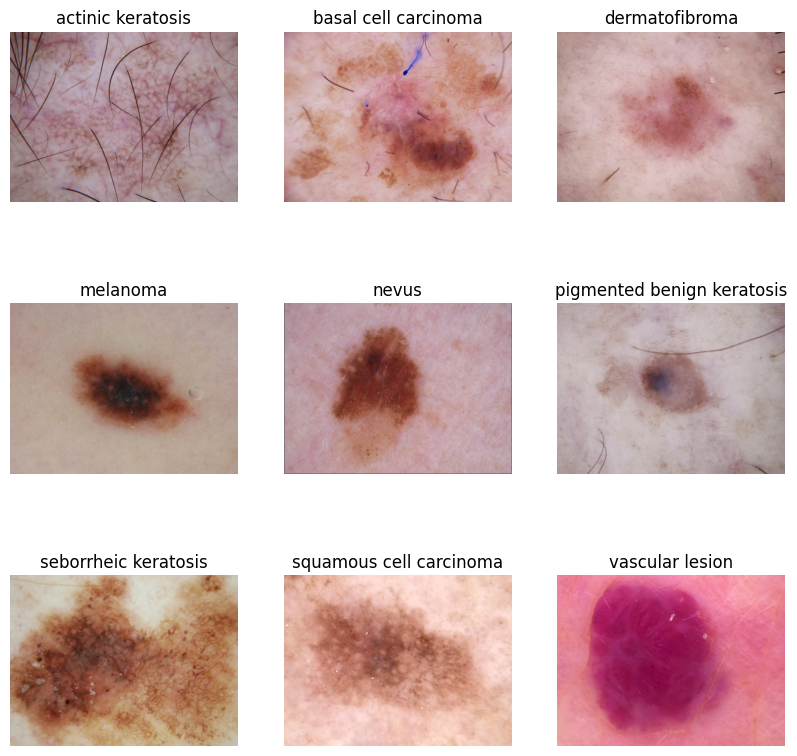

In [8]:
import matplotlib.pyplot as plt

# Displaying the first 9 images from the training dataset
# The images are displayed in a 3x3 grid with the class name as the title of each image.
# The images are displayed using matplotlib's imshow function.
# The images are read using the imread function from the PIL library.
# The images are read from the directory using the glob function from the pathlib library.

plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
# Creating the model using the Sequential class from the keras.models module.
# The model consists of a single convolutional layer with 32 filters, a kernel size of (3,3), and a relu activation function.
# The model also consists of a max pooling layer with a pool size of (2,2).
# The model also consists of a flatten layer to flatten the output of the convolutional layer.
# The model also consists of a dense layer with 512 units and a relu activation function.
# The model also consists of a dense layer with 9 units and a softmax activation function.

model=Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))


model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.25))

model.add(Dense(9,activation='softmax'))


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    31,719,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,817,801 (121.38 MB)

 Trainable params: 31,817,801 (121.38 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
# Compiling the model using the compile method.
# The model is compiled with the Adam optimizer, the sparse categorical crossentropy loss function, and the accuracy metric.
# The model is compiled with a learning rate of 0.001.
# The model is compiled with a learning rate scheduler that reduces the learning rate by a factor of 0.2 if the validation accuracy does not improve for 5 epochs.
# The model is compiled with a minimum learning rate of 1e-7.

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(
            optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    31,719,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,817,801 (121.38 MB)

 Trainable params: 31,817,801 (121.38 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
# Training the model using the fit method.
# The model is trained using the train dataset, the validation dataset, and the number of epochs.
# The model is trained with the learn_control callback to reduce the learning rate if the validation accuracy does not improve for 5 epochs.
# The model is trained with a batch size of 32.
# The model is trained with the AUTOTUNE parameter to prefetch the data and improve performance.

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 475ms/step - accuracy: 0.2073 - loss: 2.5525 - val_accuracy: 0.2998 - val_loss: 1.8713 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 575ms/step - accuracy: 0.3833 - loss: 1.7251 - val_accuracy: 0.5011 - val_loss: 1.5312 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4631 - loss: 1.4943 - val_accuracy: 0.5324 - val_loss: 1.3893 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 755ms/step - accuracy: 0.5213 - loss: 1.3105 - val_accuracy: 0.5526 - val_loss: 1.3616 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 452ms/step - accuracy: 0.5547 - loss: 1.2360 - val_accuracy: 0.4855 - val_loss: 1.5029 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 443ms/step - accuracy: 0.6077 - loss: 1.1360 - val_accuracy: 0.5302 - val_loss: 1.4591 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 989ms/step - accuracy: 0.6320 - loss: 1.030

### Visualizing training results

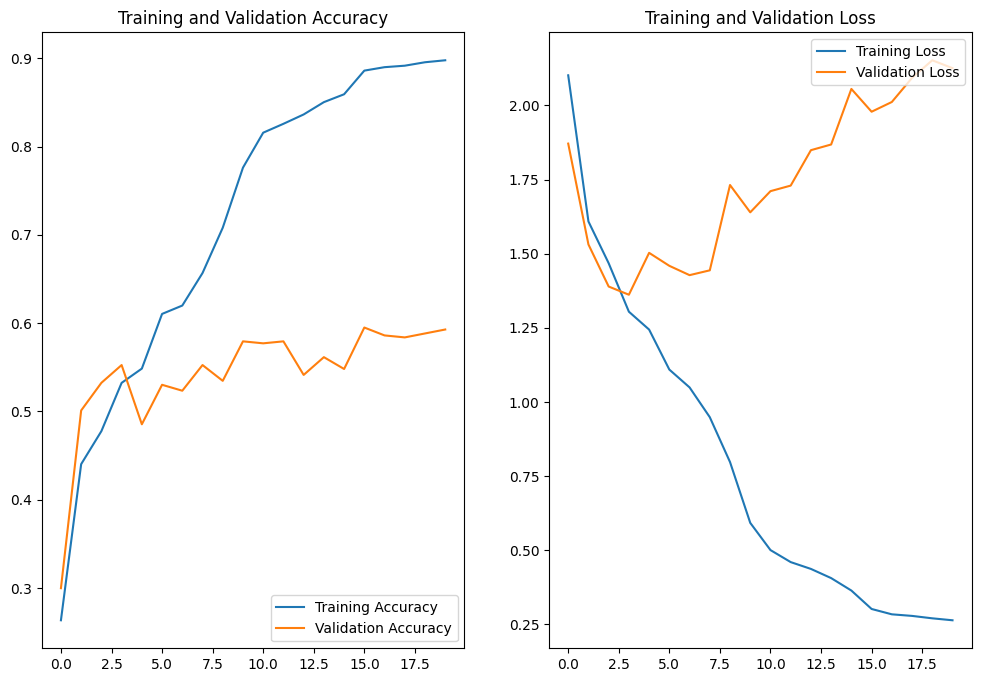

In [17]:
# Plotting the training and validation accuracy and loss.
# The training and validation accuracy and loss are plotted using matplotlib.
# The training and validation accuracy are plotted on the left, and the training and validation loss are plotted on the right.
# The plots show the training and validation accuracy and loss for each epoch.
 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

##### Observations 

##### The model is underfitting

1. The training accuracy and validation accuracy are initially similar, but the validation accuracy fluctuates between 7 and 10, indicating overfitting.

2. The training loss is very low, while the validation loss fluctuates.

From this, we can conclude that the model needs adjustments to improve its predictive performance.

In [18]:

# Data augmentation is a technique used to increase the diversity of the training dataset by applying random (but realistic) transformations such as rotation, scaling, and flipping. This can help to improve the performance and generalization of the model.
# In this case, we will use the Sequential class from the keras.layers module to create a data augmentation layer that applies random horizontal and vertical flips, random rotations, random zooms, and random contrasts to the input images.
# The data augmentation layer is then added to the model before the first convolutional layer.
# The model is then recompiled and trained with the data augmentation layer.
# The model is then evaluated on the test dataset to see if the data augmentation improves the performance of the model.


data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", 
                      input_shape=(img_height, 
                                   img_width,
                                   3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
  ]
)

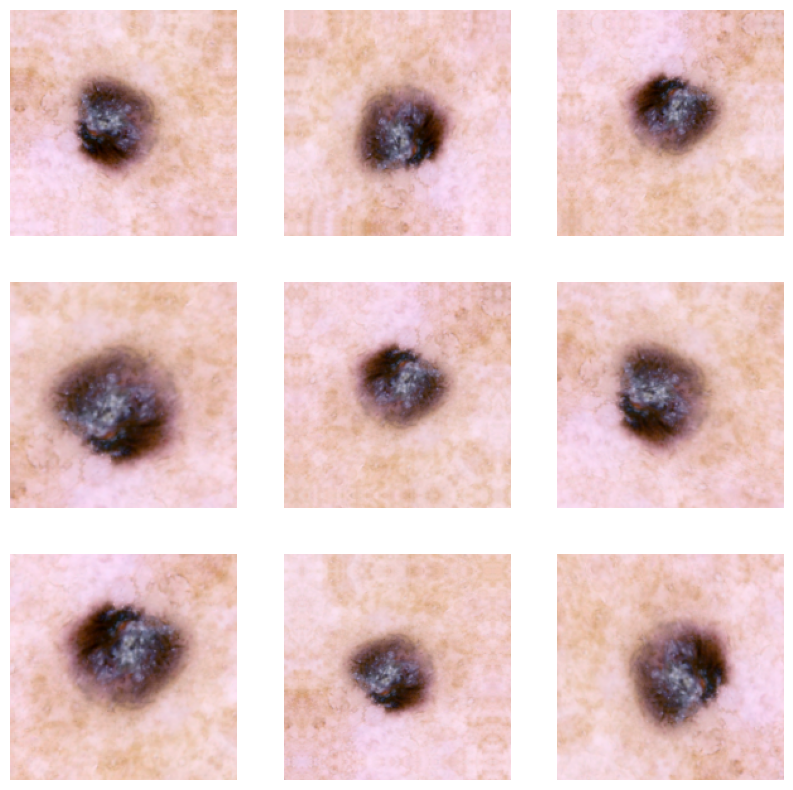

In [19]:

# Visualizing the data augmentation layer by applying it to the first 9 images from the training dataset.
# The data augmentation layer is applied to the images using the data_augmentation function.
# The images are displayed in a 3x3 grid using matplotlib's imshow function.
# The images are displayed as uint8 using the astype function.
# The images are displayed with the axis turned off.
# The images are displayed using the show function.
# The images are displayed with the title "Augmented Image".


plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model for Augmented Data, compile and train the model

In [20]:

# Creating the model using the Sequential class from the keras.models module.
# The model consists of a data augmentation layer that applies random horizontal and vertical flips, random rotations, random zooms, and random contrasts to the input images.
# The model also consists of a rescaling layer that rescales the input images to the range [0, 1].
# The model also consists of a convolutional layer with 32, 64, 128 filters, a kernel size of (3,3), and a relu activation function.
# The model also consists of a max pooling layer with a pool size of (2,2).
# The model also consists of a dropout layer with a dropout rate of 0.5.
# The model also consists of a flatten layer to flatten the output of the convolutional layer.
# The model also consists of a dense layer with 256 units and a relu activation function.
# The model also consists of a dropout layer with a dropout rate of 0.5.
# The model also consists of a dense layer with 9 units and a softmax activation function.

model = Sequential()
model.add(data_augmentation)

model.add(tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(9,activation='softmax'))


model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,955,529 (60.87 MB)

 Trainable params: 15,955,529 (60.87 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [21]:
# Compiling the model using the compile method.
# The model is compiled with the Adam optimizer, the sparse categorical crossentropy loss function, and the accuracy metric.
# The model is compiled with a learning rate of 0.001.
# The model is compiled with a learning rate scheduler that reduces the learning rate by a factor of 0.2 if the validation accuracy does not improve for 5 epochs.
# The model is compiled with a minimum learning rate of 1e-7.
# The model is compiled with a batch size of 32.

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(
              optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [22]:
# Training the model using the fit method.
# The model is trained using the train dataset, the validation dataset, and the number of epochs.
# The model is trained with the learn_control callback to reduce the learning rate if the validation accuracy does not improve for 5 epochs.
# The model is trained with a batch size of 32.
# The model is trained with the AUTOTUNE parameter to prefetch the data and improve performance.
# The model is trained with the data augmentation layer.

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 398ms/step - accuracy: 0.2021 - loss: 2.3613 - val_accuracy: 0.4094 - val_loss: 1.6801 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 398ms/step - accuracy: 0.3723 - loss: 1.7621 - val_accuracy: 0.4899 - val_loss: 1.5859 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 397ms/step - accuracy: 0.4233 - loss: 1.6067 - val_accuracy: 0.5101 - val_loss: 1.4509 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 385ms/step - accuracy: 0.4745 - loss: 1.4701 - val_accuracy: 0.5257 - val_loss: 1.4294 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 660ms/step - accuracy: 0.4983 - loss: 1.4611 - val_accuracy: 0.5213 - val_loss: 1.3991 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 844ms/step - accuracy: 0.5129 - loss: 1.3801 - val_accuracy: 0.5168 - val_loss: 1.4267 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 541ms/step - accuracy: 0.5016 - loss: 1.

### Visualizing the results

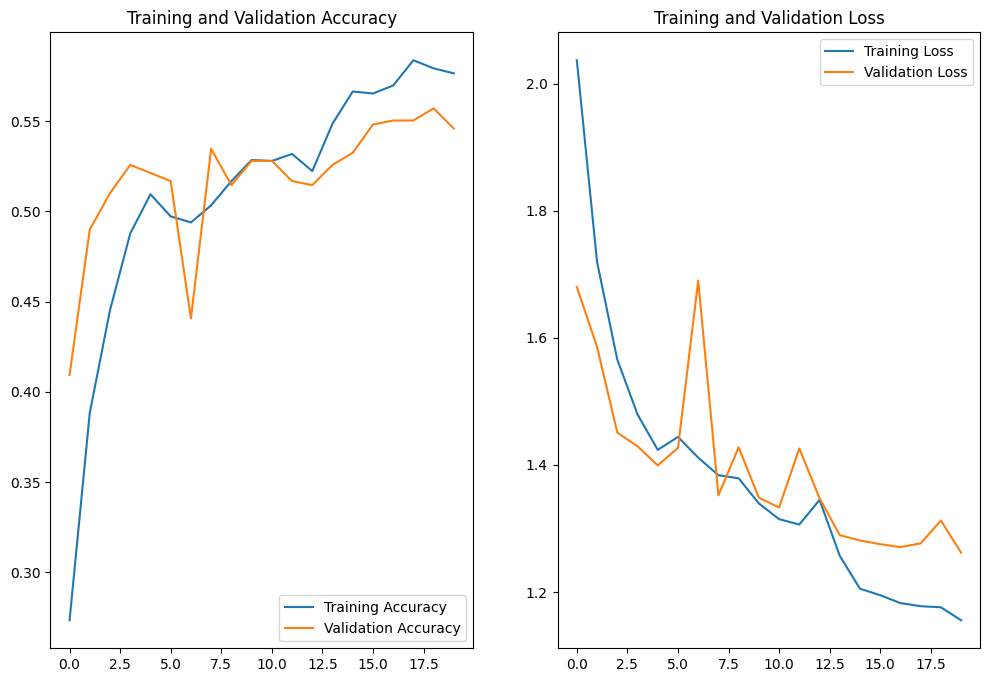

In [24]:
# Visualizing the training and validation accuracy and loss.
# The training and validation accuracy and loss are plotted using matplotlib.
# The training and validation accuracy are plotted on the left, and the training and validation loss are plotted on the right.
# The plots show the training and validation accuracy and loss for each epoch.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Data Augmentation doesnt seem to be helping as the model seems to be overfitting now

The Validation Accuracy is too low and coupled with the fact that Validation Loss is too high it means that data is getting memorized and clearly causing over-fitting.



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<function matplotlib.pyplot.show(close=None, block=None)>

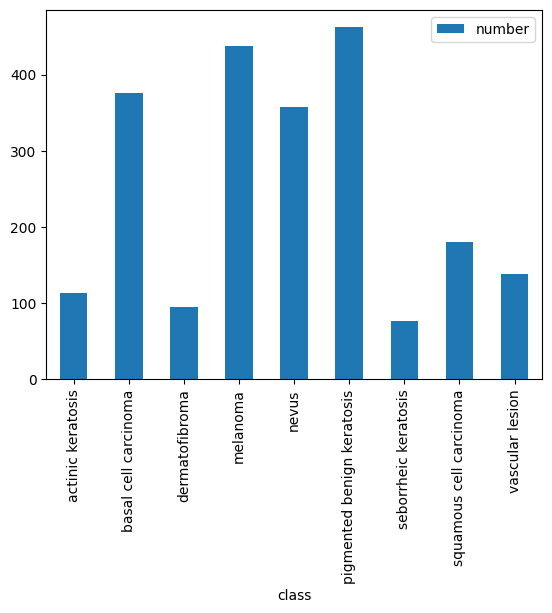

In [25]:
# 
class_diff=pd.DataFrame()

for i in range(len(class_names)):
  name1 = class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff = pd.concat([class_diff, pd.DataFrame({'class':[name1],'number':[number]})], ignore_index=True)

#class_diff

class_diff.plot.bar(x='class',y='number',rot=90)
plt.show

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? 
*   seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
*   Melanoma, pigmented benign keratosis and basal cell carcinoma are the 3 highest classes

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [ ]:
#pip install --trusted-host pypi.python.org --trusted-host pypi.org --trusted-host=files.pythonhosted.org Augmentor

In [26]:
# Designing the pipeline for data augmentation using the Augmentor library.
# The pipeline consists of a rotation operation with a probability of 0.7 and a maximum left and right rotation of 10 degrees.
# The pipeline samples 500 images from each class to augment the dataset.
# The pipeline is applied to each class in the training dataset to create augmented images.
# The pipeline is used to create a new dataset with augmented images for each class. 

path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor # type: ignore
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1789794EBD0>: 100%|██████████| 500/500 [00:02<00:00, 180.71 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x177ACFC5710>: 100%|██████████| 500/500 [00:02<00:00, 172.38 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x178978F1C90>: 100%|██████████| 500/500 [00:02<00:00, 180.25 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x17897914D10>: 100%|██████████| 500/500 [00:11<00:00, 42.87 Samples/s]   


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x178976C15D0>: 100%|██████████| 500/500 [00:11<00:00, 44.03 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1789771DC10>: 100%|██████████| 500/500 [00:02<00:00, 179.00 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x17897744150>: 100%|██████████| 500/500 [00:05<00:00, 87.85 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1789761CED0>: 100%|██████████| 500/500 [00:02<00:00, 181.07 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1789761FF10>: 100%|██████████| 500/500 [00:02<00:00, 176.96 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
# Count of images in train folders
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
# Define the path to the augmented images
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4af7bfa7-b77f-429a-979b-754abdf98124.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8ae9db16-97a5-4b8f-81a9-f00dbb145b30.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_966b2db2-f533-4138-bf99-264d9e85db31.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a8093b27-fd58-4f74-b451-c3621f1ebc0f.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b475780c-040d-456e-b9c5-5f4529575e0c.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [29]:
# Get the list of all the classes of skin cancer
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [30]:
# Define the dataframe with the path and the class of the augmented images  
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
# Get the dataframe with the path and the class of the augmented images
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2


In [33]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [37]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='training', 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ="validation", 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
# Create the train and validation datasets using the image_dataset_from_directory function from tensorflow.
# The function reads the images from the directory and resizes them to the specified height and width.
# The function also splits the data into training and validation sets based on the validation_split parameter.
# The function also shuffles the data and creates batches of the specified size.
# The function also uses the seed parameter to ensure that the data is shuffled in the same way each time the code is run.
# The function returns a tf.data.Dataset object that can be used to train a model.
# The train dataset is created using the training data directory, a seed of 123, a validation split of 0.2, a subset of "training", an image size of (img_height, img_width), and a batch size of batch_size.
# The validation dataset is created using the training data directory, a seed of 123, a validation split of 0.2, a subset of "validation", an image size of (img_height, img_width), and a batch size of batch_size.


model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(9,activation='softmax'))

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,315,721 (100.39 MB)

 Trainable params: 26,314,249 (100.38 MB)

 Non-trainable params: 1,472 (5.75 KB)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
# Compiling the model using the compile method.
# The model is compiled with the Adam optimizer, the sparse categorical crossentropy loss function, and the accuracy metric.
# The model is compiled with a learning rate of 0.001.
# The model is compiled with a learning rate scheduler that reduces the learning rate by a factor of 0.2 if the validation accuracy does not improve for 5 epochs.
# The model is compiled with a minimum learning rate of 1e-7.

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:
epochs = 30
# Train the model
# The model is trained using the train dataset, the validation dataset, and the number of epochs.

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.3450 - loss: 2.4556 - val_accuracy: 0.1180 - val_loss: 3.7223 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.5429 - loss: 1.3352 - val_accuracy: 0.2160 - val_loss: 2.8760 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.6324 - loss: 1.0196 - val_accuracy: 0.4944 - val_loss: 1.4443 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7292 - loss: 0.7629 - val_accuracy: 0.2598 - val_loss: 4.1440 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.7817 - loss: 0.6172 - val_accuracy: 0.4744 - val_loss: 1.6041 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8331 - loss: 0.4612 - val_accuracy: 0.5835 - val_loss: 1.3217 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8764 - loss: 0.

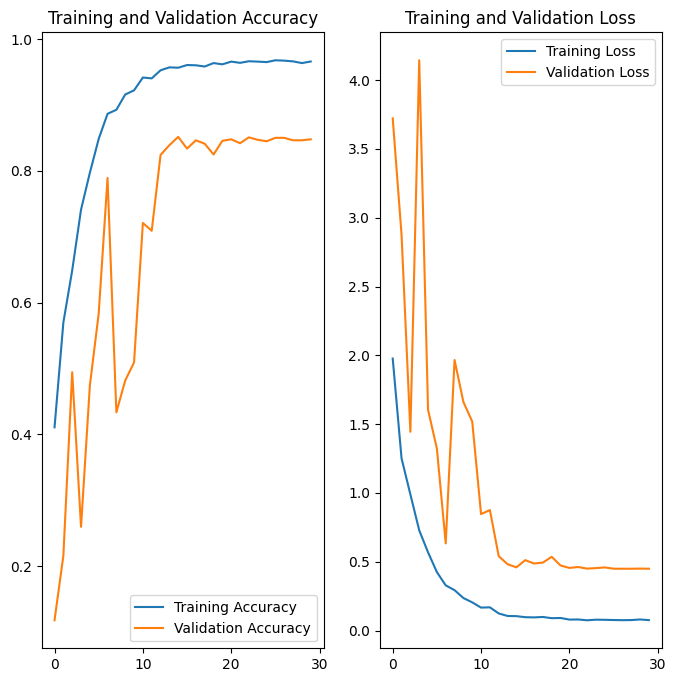

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Write your findings after the model fit, see if the issues are resolved or not?



Accuracy: Training and validation accuracy both show consistent improvement, with validation accuracy trailing slightly behind training accuracy.

Loss: Training and validation loss exhibit a steady decline.

The small gap between training and validation accuracy indicates that the model generalizes effectively to unseen data.

The model demonstrates robust training behavior, with no evident signs of overfitting or underfitting.